# Query the Storage with `ComputationFrame`s
## Why `ComputationFrame`s?
The `ComputationFrame` data structure **formalizes the natural/intuitive way you
think of the "web" of saved `@op` calls**. It gives you a "grammar" in which
operations over persisted computation graphs that are easy to think of are also
easy to implement.

In computational projects, all queries boil down to how some variables depend on
other variables: e.g., in ML you often care about what input parameters lead to
final results with certain metrics. The `mandala` storage can automatically
answer such questions when all operations along the way were `@op`s, because it
represents the "web" of saved `@op` calls, linked by how the outputs of one
`@op` are used as inputs to other `@op`s.

The `ComputationFrame` (CF) is the data structure used to explore and query this
web of calls. It's a high-level view of a collection of `@op` calls, so that
calls that serve the same role are grouped together. **The groups of calls form a
computational graph of variables and functions, which enables effective &
natural high-level operations over storage**. 

This section covers basic tools to get up to speed with CFs. For more advanced
usage, see [Advanced `ComputationFrame` tools](06_advanced_cf.md) 

## Typical workflow
Using CFs typically goes through the following stages:

- **[creation](#creating-computationframes)**: initialize a CF in various ways,
e.g. from some `Ref`s, from all calls to an `@op`, .... This CF will have a
limited view of storage because it will involve few (0 or 1) `@op`s
- **[expansion](#exploring-storage-by-expanding-computationframes)**: add more
context to the CF by adding new function nodes containing the calls that
produced/used some variable(s). The goal of this stage is to incorporate in the
CF all variables whose relationships you're interested in.
- **combination & restriction**: merge multiple CFs, restrict to subgraphs or 
specific values of the variables along some predicates. This lets you focus on
the computations you want before making expensive calls to the storage.
- **[conversion to a `pandas.DataFrame`](#extracting-dataframes-from-computationframes)**: finally,
extract a table representing the relationships between the variables in the CF
for downstream analysis.

### Toy ML pipeline
In this section, we'll work with the following toy experiment on a small ML
pipeline:

In [1]:
### define ops to train & eval a random forest model on digits dataset
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from mandala.imports import *
try:
    import rich
    from rich import print as pprint
except ImportError:
    print("rich not installed, using default print")
    pprint = print

storage = Storage()

np.random.seed(0)

@op 
def generate_dataset(random_seed=42):
    X, y = load_digits(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed)
    return X_train, X_test, y_train, y_test

@op
def train_model(X_train, y_train, n_estimators):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=2)
    model.fit(X_train, y_train)
    return model, round(model.score(X_train, y_train), 2)

@op
def eval_model(model, X_test, y_test):
    return round(model.score(X_test, y_test), 2)

In [2]:
with storage: 
    X_train, X_test, y_train, y_test = generate_dataset()
    for n_estimators in [10, 20, 40, 80]:
        model, train_acc = train_model(X_train, y_train, n_estimators=n_estimators)
        if storage.unwrap(train_acc) > 0.8: # conditional execution
            test_acc = eval_model(model, X_test, y_test)

## Creating `ComputationFrame`s
There are several ways to create a CF, all dispatched through the `storage.cf()`
method.

### From a single `Ref`
The simplest example of a CF is to create one from a `Ref`:

ComputationFrame with:
    1 variable(s) (1 unique refs)
    0 operation(s) (0 unique calls)
Computational graph:
    v

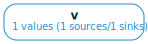

In [3]:
cf = storage.cf(test_acc)
pprint(cf) # text description of the CF 
cf.draw(verbose=True) # pictorial representation of the CF

As the description says, this is a CF with 1 variable (called `v`) and 0
operations. The variable contains 1 `Ref`, i.e. 1 value. We can examine the refs
in the variables and the calls in the operations:

In [4]:
pprint(f'Refs by variable:\n{cf.refs_by_var()}')
pprint(f'Calls by operation:\n{cf.calls_by_func()}')

Refs by variable:
{'v': {AtomRef(0.82, hid='11a...', cid='238...')}}

Calls by operation:
{}

To make this more interesting, we can call `expand_back()` (explained in more
detail later) on the CF to add the full computational history of all values in
all variables:

ComputationFrame with:
    8 variable(s) (8 unique refs)
    3 operation(s) (3 unique calls)
Computational graph:
    X_train@output_0, X_test@output_1, y_train@output_2, y_test@output_3 = 
generate_dataset(random_seed=random_seed)
    model@output_0 = train_model(y_train=y_train, n_estimators=n_estimators, X_train=X_train)
    v@output_0 = eval_model(X_test=X_test, y_test=y_test, model=model)

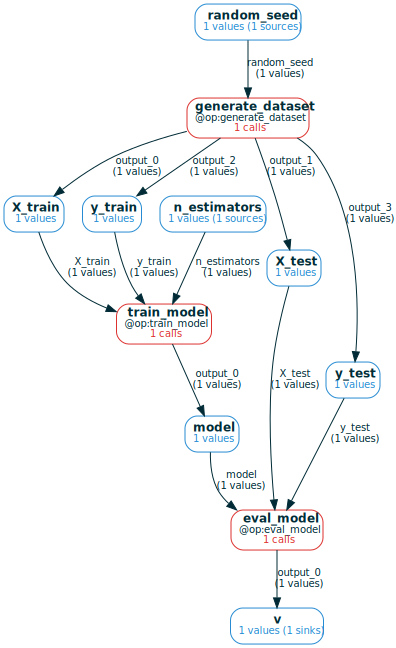

In [5]:
cf.expand_back(inplace=True, recursive=True)
pprint(cf)
cf.draw(verbose=True)

The variables added to the CF during expansion are given informative names based
on input names of functions called on these variables. The result of expansion
tells us the precise way `test_acc` was computed. We can get the values of each
variable and the calls of each function:

In [6]:
pprint({vname: storage.unwrap(refs) 
 for vname, refs in cf.refs_by_var().items()
 if vname not in ['X_train', 'X_test', 'y_train', 'y_test'] # to save space
 })

pprint(cf.calls_by_func())

{
    'v': {0.82},
    'model': {RandomForestClassifier(max_depth=2, n_estimators=80)},
    'random_seed': {42},
    'n_estimators': {80}
}

{
    'eval_model': {Call(eval_model, cid='137...', hid='d32...')},
    'generate_dataset': {Call(generate_dataset, cid='19a...', hid='c3f...')},
    'train_model': {Call(train_model, cid='3be...', hid='e60...')}
}

### From all calls to an `@op`
Another way to create a CF is to initialize is with all calls to a given `@op`:

ComputationFrame with:
    5 variable(s) (14 unique refs)
    1 operation(s) (4 unique calls)
Computational graph:
    output_0@output_0, output_1@output_1 = train_model(y_train=y_train, n_estimators=n_estimators, X_train=X_train)

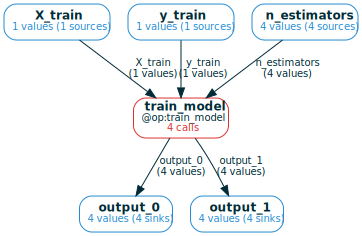

In [7]:
cf = storage.cf(train_model)
pprint(cf)
cf.draw(verbose=True)

You can extract a dataframe from any CF (explained more later); in particular,
the dataframe for the CF of a single `@op` will be the memoization table for
this `@op`:

In [8]:
print(cf.df(values='refs').to_markdown())

Extracting tuples from the computation graph:
    output_0@output_0, output_1@output_1 = train_model(n_estimators=n_estimators, y_train=y_train, X_train=X_train)
|    | y_train                                              | X_train                                              | n_estimators                                         | train_model                                   | output_0                                             | output_1                                             |
|---:|:-----------------------------------------------------|:-----------------------------------------------------|:-----------------------------------------------------|:----------------------------------------------|:-----------------------------------------------------|:-----------------------------------------------------|
|  0 | AtomRef(hid='faf...', cid='83f...', in_memory=False) | AtomRef(hid='efa...', cid='a6d...', in_memory=False) | AtomRef(hid='120...', cid='9bc...', in_memory=False) | Call(t

## 

### From groups of `Ref`s to use as variables
You can also manually initialize variables of the CF by passing a dict where
values are `Ref` iterables:

In [9]:
with storage: 
    models, test_accs = [], []
    X_train, X_test, y_train, y_test = generate_dataset()
    for n_estimators in [10, 20, 40, 80]:
        model, train_acc = train_model(X_train, y_train, n_estimators=n_estimators)
        models.append(model)
        if storage.unwrap(train_acc) > 0.8: # conditional execution
            test_acc = eval_model(model, X_test, y_test)
            test_accs.append(test_acc)

ComputationFrame with:
    2 variable(s) (6 unique refs)
    0 operation(s) (0 unique calls)
Computational graph:
    model, test_acc

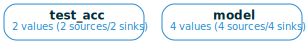

In [10]:
cf = storage.cf({'model': models, 'test_acc': test_accs})
pprint(cf)
cf.draw(verbose=True)

Again, this is not interesting unless you `expand` back and/or forward. We can 
illustrate by expanding only the `model` variable forward:

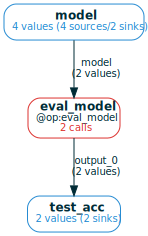

In [11]:
cf.expand_forward(varnames=['model'], inplace=True)
cf.draw(verbose=True)

The expansion algorithm figures out that the calls to `eval_model` we add
should connect to the `test_acc` variable.

### From any collection of calls
TODO

## Exploring storage by expanding `ComputationFrame`s 
Once a CF is created, you can add computational context to it by calling one of
a few methods:

In [12]:
pprint('Docstring for `expand_back`:')
pprint(cf.expand_back.__doc__)
pprint('Docstring for `expand_forward`:')
pprint(cf.expand_forward.__doc__)
pprint('Docstring for `expand_all`:')
pprint(cf.expand_all.__doc__)

Docstring for `expand_back`:

Join to the CF the calls that created all refs in the given variables
        that currently do not have a connected creator call in the CF.

        If such refs are found, this will result to the addition of 
        - new function nodes for the calls that created these refs;
        - new variable nodes for the *inputs* of these calls.

        The number of these nodes and how they connect to the CF will depend on
        the structure of the calls that created the refs. 

        Arguments:
        - `varnames`: the names of the variables to expand; if None, expand all
        the `Ref`s that don't have a creator call in any function node of the CF
        that is connected to the `Ref`'s variable node as an output.
        - `recursive`: if True, keep expanding until a fixed point is reached

Docstring for `expand_forward`:

Join the calls that consume the given variables; see `expand_back` (the 
        dual operation) for more details.

Docstring for `expand_all`:

Expand the computation frame by repeatedly applying `expand_back` and
        `expand_forward` until a fixed point is reached.

### Selective expansion with `expand_back`, `expand_forward`
You can be very precise about which calls to add to the CF. For example, you can
expand variables one by one. **When this results in convergent histories, the CF
will detect this and reuse the calls**:  

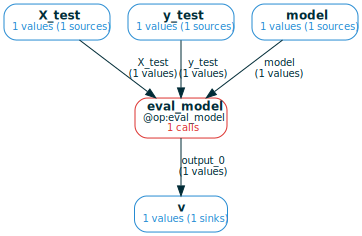

In [13]:
cf = storage.cf(test_acc)
cf = cf.expand_back('v')
cf.draw(verbose=True)

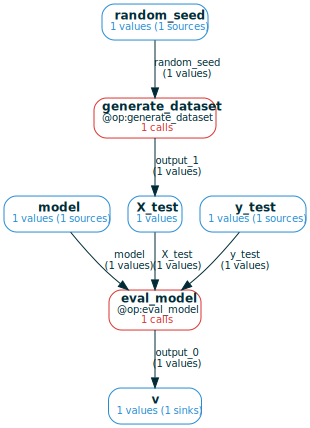

In [14]:
cf = cf.expand_back('X_test')
cf.draw(verbose=True)

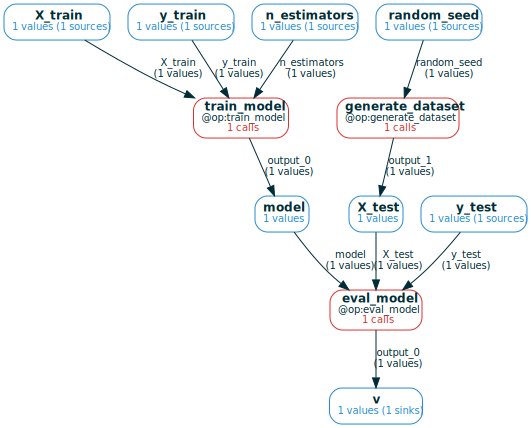

In [15]:
cf = cf.expand_back('model')
cf.draw(verbose=True)

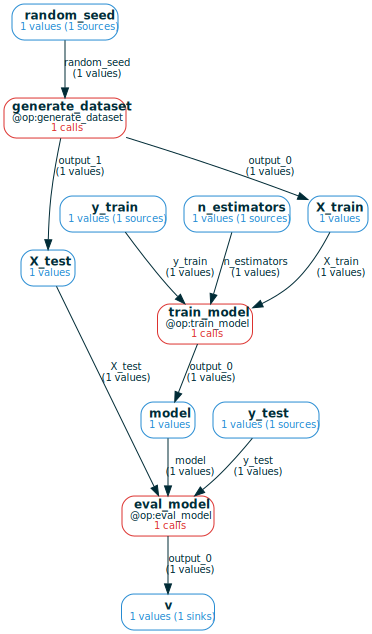

In [16]:
cf = cf.expand_back('X_train')
cf.draw(verbose=True)

When we expand `X_train` at the end, the expansion algorithm detects that the
`generate_dataset` node should be reused instead of creating a new node.

### Full expansion with `expand_all`
The easiest way to add all the calls that can be reached from a CF by calling
`expand_back` or `expand_forward` is using `expand_all`

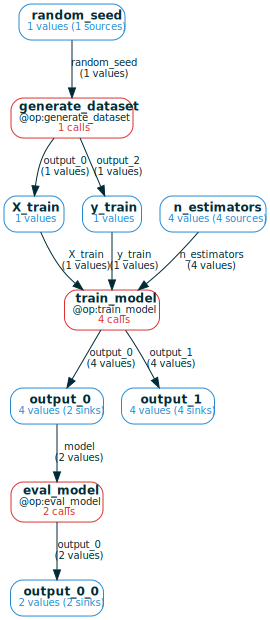

In [17]:
cf = storage.cf(train_model).expand_all()
cf.draw(verbose=True)

This adds all the calls in the storage, because they're all reachable from some
call to `train_model` by following inputs/outputs.

## Extracting `DataFrame`s from `ComputationFrame`s

### `ComputationFrame`s as generalized dataframes
You can think of `ComputationFrame`s as a generalization the familiar
`pandas.DataFrame` class:

- **instead of columns, you have a computational graph**: functions whose
input/output edges connect to variables.
- **instead of rows, you have computation traces**: variable values and function
calls that (possibly partially) follow this graph

Conversely, **a dataframe can be extracted from any computation frame** for
easier later analysis:

- the columns are the nodes in the graph (functions and variables)
- each row is a computation trace, possibly padded with `NaN`s where no
value/call is present.

### The `.df()` method
All ways to turn a CF into a DF are dispatched through a CF's `.df()` method. We
can apply this to the full storage CF we computed last:

In [18]:
cf = storage.cf(train_model).expand_all()
print(cf.df().drop(columns=['X_train', 'y_train']).to_markdown())

Extracting tuples from the computation graph:
    X_train@output_0, y_train@output_2 = generate_dataset(random_seed=random_seed)
    output_0@output_0, output_1@output_1 = train_model(n_estimators=n_estimators, y_train=y_train, X_train=X_train)
    output_0_0@output_0 = eval_model(model=output_0)
|    |   n_estimators |   random_seed | generate_dataset                                   | train_model                                   | output_0                                             | eval_model                                   |   output_0_0 |   output_1 |
|---:|---------------:|--------------:|:---------------------------------------------------|:----------------------------------------------|:-----------------------------------------------------|:---------------------------------------------|-------------:|-----------:|
|  0 |             40 |            42 | Call(generate_dataset, cid='19a...', hid='c3f...') | Call(train_model, cid='5af...', hid='514...') | RandomForestClassif

Importantly, we see that some computations only partially follow the full
computation graph, because we didn't call `eval_model` on all the `train_model`
outputs.

### What does `.df()` actually compute?
The `.df` method does roughly speaking the following:

- finds all the sink, i.e. "final", `Ref`s in the CF, i.e. the ones that are not
used as inputs to any call in a connected function node.
- for each variable's sink `Ref`s, it computes a table where 
    - columns are variables and functions that these `Ref`s depend on
    - rows contain the set of `Ref`/`Call` dependencies from each such node
- joins these tables over all the variables containing sink `Ref`s along their
shared columns

## Visualizing and summarizing `ComputationFrame`s
CFs are complex data structures, and benefit from several kinds of high-level
summaries.

### The `.draw()` method
We've used the `.draw()` method a bunch of times so far. Let's revisit the most
recent CF:

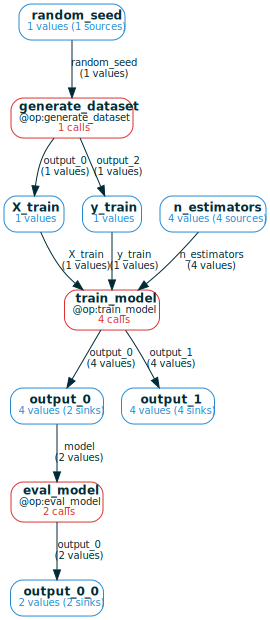

In [19]:
cf.draw(verbose=True)

The `.draw()` method shows the computational graph of a CF and how many
calls/refs there are in each function/variable. When called with `verbose=True`,
this method shows a summary of how the variable values and function calls
connect across the CF:

- **source (i.e. initial) `Ref`s** in each variable: the `Ref`s in this variable
that aren't outputs of any call in a function node using the variable as output.
- **sink (i.e. final) `Ref`s** in each variable: dual to source refs, these are
the `Ref`s that are not inputs to calls in any function node using the variable
as input.
- **edge `Ref`s** for each edge: for edges that are inputs to functions, this is
the number of refs from the input variable that are used in calls to the
function. For edges that are outputs of functions, this is the number of refs in
the output variable created by calls in the function node.

### Printing the computation graph of a `ComputationFrame`
The computational graph of a CF is part of its `repr()`, but you can also print
just the graph:

In [20]:
cf.print_graph()

X_train@output_0, y_train@output_2 = generate_dataset(random_seed=random_seed)
output_0@output_0, output_1@output_1 = train_model(y_train=y_train, n_estimators=n_estimators, X_train=X_train)
output_0_0@output_0 = eval_model(model=output_0)


Note that outputs are appended with `@output_0`, .... This is to indicate the
name each output is bound to, in case some outputs are missing from the graph
(which is possible, because CFs can represent partial computations).